# Stock Price Forecasting with LSTM
This notebook pulls historical stock data, engineers features, trains an LSTM model, and evaluates its performance.


In [16]:
# PARAMETERS
TICKER    = "AAPL"
START     = "2015-01-01"
END       = "2025-04-20"
N_STEPS   = 50        # window size for sequences
BATCH_SIZE= 32
EPOCHS    = 100
!pip install --upgrade yfinance

In [17]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr


In [18]:
df = yf.download(
    TICKER,
    start=START,
    end=END,
    progress=False
)
df.head()


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320433,24.789802,23.879981,24.778679,212818400
2015-01-05,23.635290,24.169170,23.448433,24.089088,257142000
2015-01-06,23.637506,23.897772,23.274912,23.699792,263188400
2015-01-07,23.968956,24.069058,23.735383,23.846608,160423600
2015-01-08,24.889906,24.947743,24.180291,24.298190,237458000


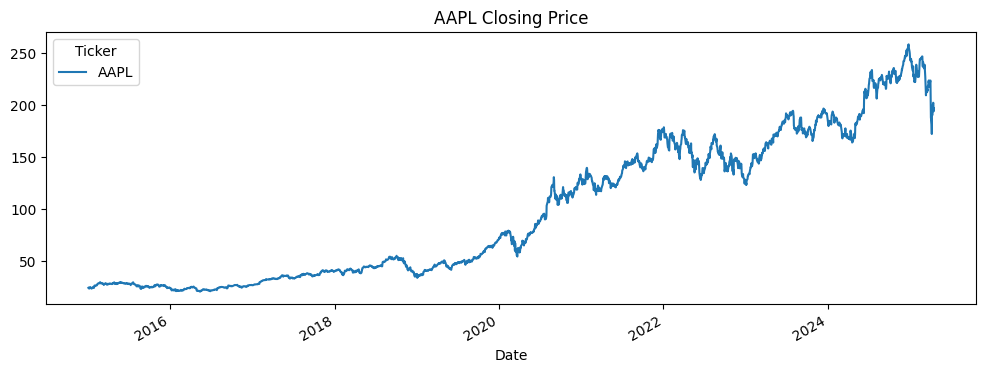

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

In [19]:
# 3️⃣ Exploratory Data Analysis
df['Close'].plot(title=f"{TICKER} Closing Price", figsize=(12,4))
plt.show()

df.isna().sum()


In [20]:
# 4️⃣ Feature Engineering
df['MA10'] = df['Close'].rolling(10).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df.dropna(inplace=True)
df.tail()

Price,Close,High,Low,Open,Volume,MA10,MA50
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2025-04-11,198.149994,199.539993,186.059998,186.100006,87435900,200.208002,224.458866
2025-04-14,202.520004,212.940002,201.160004,211.440002,101352900,198.247002,223.794450
2025-04-15,202.139999,203.509995,199.800003,201.860001,51343900,196.142001,223.282058
2025-04-16,194.270004,200.699997,192.369995,198.360001,59732400,193.180002,222.516572
2025-04-17,196.979996,198.830002,194.419998,197.199997,51334300,192.559001,221.811878


In [21]:
# 5️⃣ Preprocessing & Windowing
features = ['Close','MA10','MA50']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

X, y = [], []
for i in range(N_STEPS, len(scaled)):
    X.append(scaled[i-N_STEPS:i])
    y.append(scaled[i, 0])     # next-day closing price

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [22]:
# 6️⃣ Model Architecture
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(N_STEPS, len(features))),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# 7️⃣ Training
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[es]
)


/Users/iowastate/Sophomore/Spring/AI 201X/stock-forecasting/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4661e-04 - val_loss: 0.0015
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.0653e-04 - val_loss: 0.0015
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4499e-04 - val_loss: 9.8189e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2930e-04 - val_loss: 9.7523e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7515e-04 - val_loss: 0.0013
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8146e-04 - val_loss: 7.9294e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9513e-04 - val_loss: 9.9951e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9482e-04 - val_loss: 9.1090e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.3093e-04 - val_loss: 7.9072e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8117e-04 - val_l

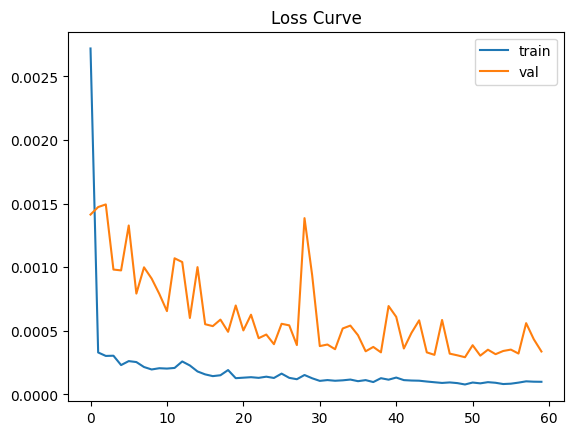

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test RMSE: 0.0674


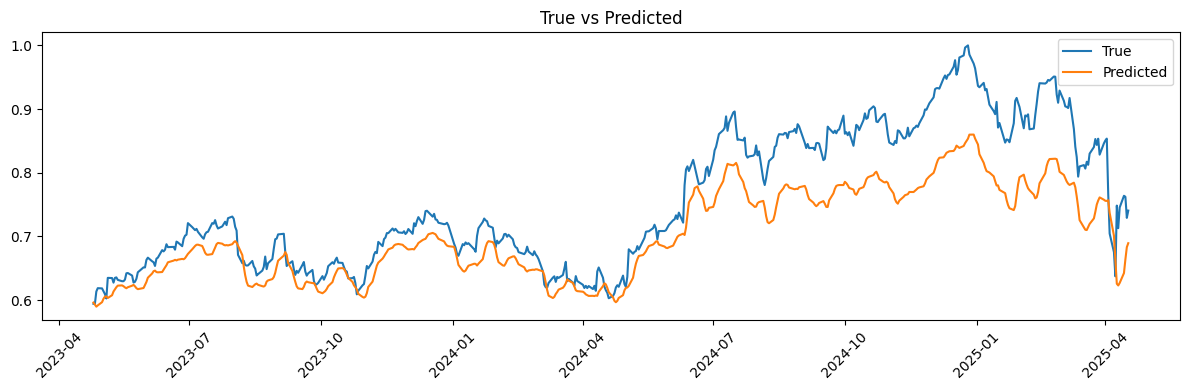

In [23]:
# 8️⃣ Evaluation
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.title('Loss Curve'); plt.show()

preds = model.predict(X_test).flatten()
rmse = np.sqrt(np.mean((preds - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")

dates = df.index[-len(y_test):]

plt.figure(figsize=(12,4))
plt.plot(dates, y_test,  label='True')
plt.plot(dates, preds,   label='Predicted')
plt.legend()
plt.title('True vs Predicted')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# 1. Scalers
feature_scaler = MinMaxScaler()
target_scaler  = MinMaxScaler()

features = df[['Close','MA10','MA50']]
targets  = df[['High','Low']]

scaled_X = feature_scaler.fit_transform(features)
scaled_y = target_scaler.fit_transform(targets)

# 2. Build windows
X, y = [], []
for i in range(N_STEPS, len(df)):
    X.append(scaled_X[i-N_STEPS:i])
    y.append(scaled_y[i])
X, y = np.array(X), np.array(y)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 4. Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(N_STEPS, X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dense(2)   # predicts [high, low]
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
          validation_split=0.2, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# 5. Live forecast
window = df[['Close','MA10','MA50']].iloc[-N_STEPS:]
scaled_window = feature_scaler.transform(window)
X_live = scaled_window.reshape(1, N_STEPS, scaled_window.shape[1])

scaled_pred = model.predict(X_live)[0]               # [high_scaled, low_scaled]
high_pred, low_pred = target_scaler.inverse_transform([scaled_pred])[0]

hi, lo = max(high_pred, low_pred), min(high_pred, low_pred)
print(f"Next High (clamped): ${hi:.2f}")
print(f"Next Low  (clamped): ${lo:.2f}")


Epoch 1/100


/Users/iowastate/Sophomore/Spring/AI 201X/stock-forecasting/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0158 - val_loss: 0.0013
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.9930e-04 - val_loss: 0.0013
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7261e-04 - val_loss: 0.0013
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9808e-04 - val_loss: 0.0014
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.6931e-04 - val_loss: 0.0011
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5991e-04 - val_loss: 0.0012
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7819e-04 - val_loss: 0.0013
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2987e-04 - val_loss: 9.7233e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5844e-04 - val_loss: 9.5769e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2340e-04 - val_loss: 0.0016
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8125e-04 - val_loss: 0.0011
Epoch 12/100
50/

In [25]:
import pickle

# 1) Save the trained Keras model in native .keras format
model.save("stock_model.keras")

# 2) Serialize your scalers so you can use them later in the web app
with open("feature_scaler.pkl", "wb") as f:
    pickle.dump(feature_scaler, f)
with open("target_scaler.pkl", "wb") as f:
    pickle.dump(target_scaler, f)

print("Model and scalers saved to disk.")


Model and scalers saved to disk.
